# Welcome to MSSE CHEM277B Final Project 

We aim to develop a supervised learning ANN model applied to the ANI-1 data set which is a dataset of more than 20 million density function theory calculated energies for non-equilibrium conformations from 57k small molecules. The molecules included contain from one to eight C, N, and O atoms. The non-equilibrium conformations were generated using a normal mode sampling scheme.

### Student Name: Charis Liao 

In [ ]:
!pip install torchani
!pip install torch 
!pip install numpy

In [1]:
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable


In [19]:
# import modules 
import torchani 
import torch
from torch import nn
from math import sqrt
import numpy as np
from pyanitools import anidataloader
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchani.units import hartree2kcalmol
from torch.optim import SGD, Adam
from functools import wraps
from time import time
import math
from sklearn.model_selection import train_test_split, KFold
from torch import Tensor
from typing import Tuple, NamedTuple, Optional
import matplotlib.pyplot as plt
%matplotlib inline


import torch.optim as optim
from tqdm import tqdm


In [2]:
# check if GPU is available
torch.cuda.is_available()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 2.1 Data Selection 
In order for a neural network to “learn” effectively, having a suitable dataset is utmost important. In our case, we acquired the ANI-1 dataset, a dataset of 20 million calculated off-equilibirum conformation for organic molecules, for training our network to predict molecular energies.4 The dataset consists of a total of 8 files, each categorized based on the number of heavy atoms present in the molecules. To optimize computational resources and save time, we have set a training limit of up to four heavy atoms in order to focus on a specific subset of molecules. The dataset also contains a .py file to assist users in loading the data.

# 2.2 Hyperparameters 

In [4]:
# defining hyperparameter for aev computer 
Rcr = 5.2
EtaR = torch.tensor([16], dtype=torch.float)
ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250])
Rca = 3.5
EtaA = torch.tensor([8], dtype=torch.float)
ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float)
ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243]) 
Zeta = torch.tensor([32], dtype=torch.float)


species_order = ['H', 'C', 'N', 'O']
num_species = len(species_order)


aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)
aev_dim = aev_computer.aev_length

# 2.3 ANI model 

In [5]:
import torch
import torch.nn as nn
import torchani

# Define the ANI model
class ANI(nn.Module):
    def __init__(self, architectures):
        super().__init__()
        self.sub_nets = nn.ModuleDict({
            "0" : ANI_sub(architectures["H"]),
            "1" : ANI_sub(architectures["C"]),
            "2" : ANI_sub(architectures["N"]),
            "3" : ANI_sub(architectures["O"])
        })
        

    def forward(self, species_aev):
        species, aev = species_aev
        assert species.shape == aev.shape[:-1]

        atomic_energies = self.compute_atomic_energies((species, aev))
        total_energies = torch.sum(atomic_energies, dim=1)
        
        return total_energies
        

    def compute_atomic_energies(self, species_aev):
        species, aev = species_aev
        assert species.shape == aev.shape[:-1]
        species_ = species.flatten()
        aev = aev.flatten(0, 1)

        output = aev.new_zeros(species_.shape)

        for i, m in enumerate(self.sub_nets.values()):
            mask = (species_ == i)
            midx = mask.nonzero().flatten()
            if midx.shape[0] > 0:
                input_ = aev.index_select(0, midx)
                output.masked_scatter_(mask, m(input_).flatten())
        output = output.view_as(species)
        return output

# Define the ANI sub-network
class ANI_sub(nn.Module):
    def __init__(self, architecture):
        super().__init__()
        self.network = architecture

    def forward(self, aev):
        atomic_energy = self.network(aev)
        return atomic_energy


# Define the architectures for different atom types
architectures = {
    
    "H" : torch.nn.Sequential(
        torch.nn.Linear(aev_dim, 160),
        torch.nn.CELU(0.1),
        torch.nn.Linear(160, 128),
        torch.nn.CELU(0.1),
        torch.nn.Linear(128, 96),
        torch.nn.CELU(0.1),
        torch.nn.Linear(96, 1)
    ),
    "C" : torch.nn.Sequential(
            torch.nn.Linear(aev_dim, 144),
            torch.nn.CELU(0.1),
            torch.nn.Linear(144, 112),
            torch.nn.CELU(0.1),
            torch.nn.Linear(112, 96),
            torch.nn.CELU(0.1),
            torch.nn.Linear(96, 1)
    ),

    "N" : torch.nn.Sequential(
            torch.nn.Linear(aev_dim, 128),
            torch.nn.CELU(0.1),
            torch.nn.Linear(128, 112),
            torch.nn.CELU(0.1),
            torch.nn.Linear(112, 96),
            torch.nn.CELU(0.1),
            torch.nn.Linear(96, 1)
    ),

    "O" : torch.nn.Sequential(
            torch.nn.Linear(aev_dim, 128),
            torch.nn.CELU(0.1),
            torch.nn.Linear(128, 112),
            torch.nn.CELU(0.1),
            torch.nn.Linear(112, 96),
            torch.nn.CELU(0.1),
            torch.nn.Linear(96, 1)
    )
}

# print(ani_model)


# 2.4 Training and Validating the Network 

In [8]:
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [15]:
class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size):
        """ 
        Initializes the Trainer class for training the model.

        Args:
            model (nn.Module): A PyTorch model.
            optimizer_type (str): Type of optimizer, 'adam' or 'sgd'.
            learning_rate (float): Learning rate for the optimizer.
            epoch (int): Number of training epochs.
            batch_size (int): Batch size for training.
        """
        self.model = model

        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(list(model.parameters()), learning_rate)
        elif optimizer_type == 'adam_l2':
            self.optimizer = Adam(model.parameters(), learning_rate, weight_decay=1e-5)
            
        self.epoch = epoch
        self.batch_size = batch_size
      


    @timing
    def train(self, datafiles, l2=False,silent=False):
        """
        Trains the model with the specified arguments.

        Args:
            datafiles: List[str]
                List of data files.
            l2: bool, optional
                Flag indicating whether to compute the loss with L2 regularization. Default is False.
            silent: bool, optional
                Flag controlling whether or not to print the train and val error during training. Default is False.
        
        Returns:
            model: nn.Module
                The trained PyTorch model.
            losses: dict
                A dictionary containing the training and validation losses.
                Format: {'loss': [float], 'val_loss': [float]}
        """
        h5files = datafiles
        losses = []
        val_losses = []
        
        
        for i in range(self.epoch):
            epoch_losses = []
            epoch_val_losses = []
            for d in h5files:
                subset_loss = 0.0
                subset_val_loss = 0.0
            
                for mol in anidataloader(d):
                
                    S = mol['species']
                    X = mol['coordinates']
                    E = mol['energies']
                   
        
                    mapping = {"H": 0, "C": 1, "N": 2, "O": 3}
                    species = np.array([mapping[atom] for atom in S])  
                    species = np.tile(species, (X.shape[0], 1))
                    species = torch.tensor(species)
                    X = torch.tensor(X)

                  
                    species, aevs = aev_computer((species, X))

                    # Split into training and validation sets
                    species_train, species_test, \
                    aevs_train, aevs_test, \
                    E_train, E_test = train_test_split(species, aevs, E, test_size=0.2, random_state=42)

                    # Move the training and val data to the GPU
                    species_train = species_train.to(device)
                    species_test = species_test.to(device)
                    aevs_train = aevs_train.to(device)
                    aevs_test = aevs_test.to(device)
                    E_train = torch.tensor(E_train).to(device)
                    E_test = torch.tensor(E_test).to(device)

                    # Create the datasets and load for the training and validation
                    train_dataset = TensorDataset(species_train, aevs_train, E_train)
                    val_dataset = TensorDataset(species_test, aevs_test, E_test)
                    train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
                    val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)

                    # Start training 
                    self.model.train()
                    batch_loss = 0.0
                    val_loss = 0.0
   
                    for batch in train_dataloader:
                        species_batch, aevs_batch, E_batch = batch
                        species_batch = species_batch.to(device)
                        aevs_batch = aevs_batch.to(device)
                        E_batch = E_batch.to(device)

                        batch_importance = len(species_batch) / len(species_train)
                        
                        E_pred = self.model((species_batch, aevs_batch)).double().to(device)

                      
                        loss_fn = torch.nn.MSELoss()
                        loss = loss_fn(E_pred, E_batch.double())

                        if l2:
                            ### Compute the loss with L2 regularization ###
                            l2_lambda = 1e-5
                            l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                            loss = loss + l2_lambda * l2_norm
                            
                        # Backpropagate and update the weights
                        self.optimizer.zero_grad()
                        loss.backward()
                        self.optimizer.step()
                        batch_loss += loss.item() * batch_importance
                   
                   
                    epoch_losses.append(batch_loss)
                    val_loss = self.evaluate(val_dataset)
                    epoch_val_losses.append(val_loss)

            
            # Calculate the mean loss for the current epoch
            train_RMSE = sqrt(np.mean(epoch_losses)) * 627.509 # Hartree to kcal/mol
            val_RMSE = sqrt(np.mean(epoch_val_losses)) * 627.509
           
            
            # Append the mean losses to the overall losses
            losses.append(train_RMSE)
            val_losses.append(val_RMSE)

            # Print every 10 epochs
            if i % 10 == 0:
                print('Epoch: %d, Training Loss (RMSE): %f kcal/mol, Validation Loss (RMSE): %f kcal/mol' % 
                      (i, train_RMSE, val_RMSE))

    
        # Return the model and the dictionary of losses
        return self.model, {'loss': losses, 'val_loss': val_losses}
    
    def evaluate(self, dataset, print_loss=False):
        """
        Evaluates the model on the given inputs and outputs.

        Parameters
        ----------
        inputs : SpeciesAEVsEnergy
            A custom dataset containing species, AEVs, and energies.
        outputs : torch.Tensor
            A tensor of energies.

        Returns
        -------
        float
            The mean squared error of the model.
        """
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        losses = 0

        for batch in test_dataloader:
            batch_importance = len(batch[0]) / len(dataset)
            species_batch, aevs_batch, E_batch = batch
            species_batch = species_batch.to(device)
            aevs_batch = aevs_batch.to(device)
            E_batch = E_batch.to(device)

            with torch.no_grad():
                E_pred = self.model((species_batch, aevs_batch))
                loss_fn = torch.nn.MSELoss()
                loss = loss_fn(E_pred, E_batch)
            losses += loss.item() * batch_importance

            if print_loss:
                print("Loss: %.3f" % losses)

        return losses

    

In [16]:
def train_model(files, epochs, draw_curve=True, early_stop=False, batchsize=128, optimizer='adam',lr=1e-3,l2=False):

    model= ANI(architectures)
    model.to(device)

    print(f"{ANI.__name__} parameters:", sum([len(item.flatten()) for item in model.parameters()]))
    trainer = Trainer(model, optimizer, lr, epochs, batchsize)
    model, log=trainer.train(files,l2=False)
    
    if draw_curve:
        plt.plot(log['loss'], label="train")
        plt.plot(log['val_loss'], label="val")
        plt.title(f"Training v.s. Validation Loss")
        plt.legend()
        plt.show()
    
    return model

## Data trained with all four files up to 4 heavy atoms. 

ANI parameters: 326660
Epoch: 0, Training Loss (RMSE): 335.960115 kcal/mol, Validation Loss (RMSE): 149.322409 kcal/mol
Epoch: 10, Training Loss (RMSE): 287.555539 kcal/mol, Validation Loss (RMSE): 107.613179 kcal/mol
Epoch: 20, Training Loss (RMSE): 166.475851 kcal/mol, Validation Loss (RMSE): 72.844373 kcal/mol
Epoch: 30, Training Loss (RMSE): 209.711847 kcal/mol, Validation Loss (RMSE): 101.913549 kcal/mol
Epoch: 40, Training Loss (RMSE): 252.160210 kcal/mol, Validation Loss (RMSE): 75.952280 kcal/mol
Epoch: 50, Training Loss (RMSE): 254.872995 kcal/mol, Validation Loss (RMSE): 129.027510 kcal/mol
Epoch: 60, Training Loss (RMSE): 247.083766 kcal/mol, Validation Loss (RMSE): 101.567489 kcal/mol
Epoch: 70, Training Loss (RMSE): 191.885887 kcal/mol, Validation Loss (RMSE): 72.049302 kcal/mol
Epoch: 80, Training Loss (RMSE): 201.301136 kcal/mol, Validation Loss (RMSE): 66.069982 kcal/mol
Epoch: 90, Training Loss (RMSE): 180.245513 kcal/mol, Validation Loss (RMSE): 87.509746 kcal/mol
fun

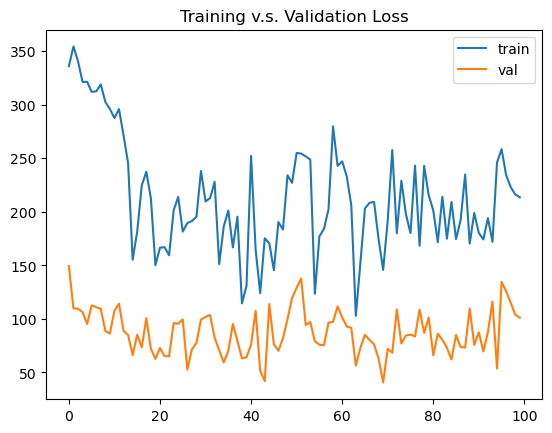

In [17]:
files = [
    "/global/scratch/users/charisliao/ANI-1_release/ani_gdb_s01.h5",
    "/global/scratch/users/charisliao/ANI-1_release/ani_gdb_s02.h5",
    "/global/scratch/users/charisliao/ANI-1_release/ani_gdb_s03.h5",
    "/global/scratch/users/charisliao/ANI-1_release/ani_gdb_s04.h5"
]

model = train_model(files, 100)

## Data trained with one heavy atom. 

ANI parameters: 326660
Epoch: 0, Training Loss (RMSE): 184.997042 kcal/mol, Validation Loss (RMSE): 55.230936 kcal/mol
Epoch: 10, Training Loss (RMSE): 3.542999 kcal/mol, Validation Loss (RMSE): 3.624673 kcal/mol
Epoch: 20, Training Loss (RMSE): 3.273785 kcal/mol, Validation Loss (RMSE): 3.142879 kcal/mol
Epoch: 30, Training Loss (RMSE): 3.213849 kcal/mol, Validation Loss (RMSE): 3.017707 kcal/mol
Epoch: 40, Training Loss (RMSE): 4.230046 kcal/mol, Validation Loss (RMSE): 3.214402 kcal/mol
Epoch: 50, Training Loss (RMSE): 5.197553 kcal/mol, Validation Loss (RMSE): 3.002120 kcal/mol
Epoch: 60, Training Loss (RMSE): 2.559949 kcal/mol, Validation Loss (RMSE): 2.701236 kcal/mol
Epoch: 70, Training Loss (RMSE): 17.094289 kcal/mol, Validation Loss (RMSE): 10.113320 kcal/mol
Epoch: 80, Training Loss (RMSE): 5.868349 kcal/mol, Validation Loss (RMSE): 4.995003 kcal/mol
Epoch: 90, Training Loss (RMSE): 4.036935 kcal/mol, Validation Loss (RMSE): 2.901616 kcal/mol
func:'train'  took: 61.4288 sec


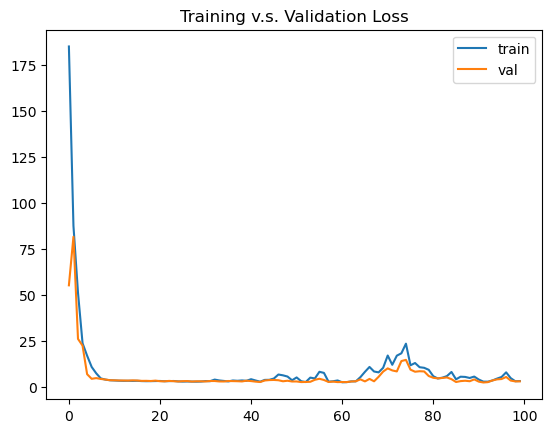

In [25]:
files = ["/global/scratch/users/charisliao/ANI-1_release/ani_gdb_s01.h5"]
one_heavy_atom_model = train_model(files, 100)

## Data trained with two heavy atoms. 

ANI parameters: 326660
Epoch: 0, Training Loss (RMSE): 218.051298 kcal/mol, Validation Loss (RMSE): 136.878630 kcal/mol
Epoch: 10, Training Loss (RMSE): 112.439497 kcal/mol, Validation Loss (RMSE): 71.150037 kcal/mol
Epoch: 20, Training Loss (RMSE): 97.296036 kcal/mol, Validation Loss (RMSE): 62.197523 kcal/mol
Epoch: 30, Training Loss (RMSE): 207.990881 kcal/mol, Validation Loss (RMSE): 77.327578 kcal/mol
Epoch: 40, Training Loss (RMSE): 43.792298 kcal/mol, Validation Loss (RMSE): 25.892662 kcal/mol
Epoch: 50, Training Loss (RMSE): 55.477420 kcal/mol, Validation Loss (RMSE): 50.864940 kcal/mol
Epoch: 60, Training Loss (RMSE): 64.699078 kcal/mol, Validation Loss (RMSE): 58.091442 kcal/mol
Epoch: 70, Training Loss (RMSE): 46.597343 kcal/mol, Validation Loss (RMSE): 38.775153 kcal/mol
Epoch: 80, Training Loss (RMSE): 48.721569 kcal/mol, Validation Loss (RMSE): 27.400303 kcal/mol
Epoch: 90, Training Loss (RMSE): 51.829702 kcal/mol, Validation Loss (RMSE): 56.031599 kcal/mol
func:'train'  

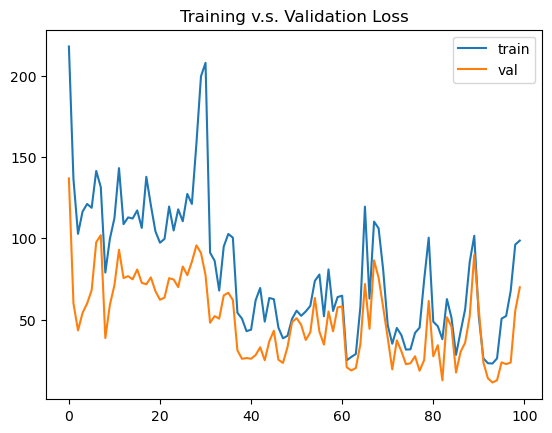

In [28]:
files = ["/global/scratch/users/charisliao/ANI-1_release/ani_gdb_s02.h5"]
two_heavy_atoms_model = train_model(files, 100)

## Data trained with three and four heavy atoms. (Incomplete. Savio kicked me out) 

In [ ]:
files = ["/global/scratch/users/charisliao/ANI-1_release/ani_gdb_s03.h5"]
three_heavy_atoms_model = train_model(files, 100)

In [ ]:
files = ["/global/scratch/users/charisliao/ANI-1_release/ani_gdb_s04.h5"]
four_heavy_atoms_model = train_model(files, 100)

ANI parameters: 326660
Epoch: 0, Training Loss (RMSE): 104.305650 kcal/mol, Validation Loss (RMSE): 22.184501 kcal/mol
Epoch: 10, Training Loss (RMSE): 119.987237 kcal/mol, Validation Loss (RMSE): 42.320048 kcal/mol
Epoch: 20, Training Loss (RMSE): 102.435835 kcal/mol, Validation Loss (RMSE): 34.862294 kcal/mol
Epoch: 30, Training Loss (RMSE): 146.321757 kcal/mol, Validation Loss (RMSE): 12.474458 kcal/mol
